In [22]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset

from models.networks import get_model
from data_utils.data_stats import *


dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10



# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- list of altered datasets -------
altered_datasets = ['cifar10_permuted_block_size_8.pth', 'cifar10_permuted_block_size_16.pth', 'cifar10_fgsa_VGG.pth', 'cifar10_fgsa_MLP.pth', 'cifar10_fgsa_resnet50.pth', 'cifar10_fgsa_densenet169.pth','cifar10_fgsa_vgg13_bn_eval_10.pth','cifar10_fgsa_resnet50_eval_10.pth']


# ---------- Load the CIFAR-10 test dataset -------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#--------- Load the permuted dataset ----------

class CustomDataset(Dataset):
    def __init__(self, dataset_dict, transform = None):
        self.dataset_dict = dataset_dict
        self.transform = transform

    def __len__(self):
        return len(self.dataset_dict)

    def __getitem__(self, index):
        data = self.dataset_dict[index]
        image = data['image']
        if self.transform:
            image = self.transform(data['image'])
        label = data['label']

        return image, label

# Load the dataset dictionary
loaded_dataset = torch.load(altered_datasets[-1])

# Create an instance of the CustomDataset
permuted_dataset = CustomDataset(loaded_dataset, transform = transform)
permuted_loader = DataLoader(permuted_dataset, batch_size=1024, shuffle=False)


# ------------- Load the pretrained model ------------

pretrained_model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint='in21k_cifar10')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

# -----------calculate accuracies -----------

def accuracy_calc(loader, classes, dataset):
    num_classes = len(classes)
    # Initialize a dictionary to store per-class counts
    class_counts = {class_idx: {'correct': 0, 'total': 0} for class_idx in range(num_classes)}

    with torch.no_grad():
        for inputs, labels in loader:

            inputs = torch.reshape(inputs, (inputs.shape[0], -1))
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update counts for each class
            for class_idx in range(num_classes):
                class_mask = labels == class_idx
                class_total = class_mask.sum().item()
                class_correct = (predicted[class_mask] == class_idx).sum().item()

                class_counts[class_idx]['correct'] += class_correct
                class_counts[class_idx]['total'] += class_total

    # Calculate per-class accuracy
    per_class_accuracy = {class_idx: class_counts[class_idx]['correct'] / class_counts[class_idx]['total']
                        for class_idx in range(num_classes)}

    # Print per-class accuracy
    total_accuracy = 0
    for class_idx in range(num_classes):
        print(f'{dataset} accuracy for {classes[class_idx]}: {100 * per_class_accuracy[class_idx]:.2f}%') # 
        total_accuracy += per_class_accuracy[class_idx]

    print(f'{dataset} total accuracy : {100 * total_accuracy/10:.2f}%')

classes  = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
#accuracy_calc(test_loader, classes, 'CIFAR10')
accuracy_calc(permuted_loader, classes, 'Permuted CIFAR10')



Files already downloaded and verified
Weights already downloaded
Load_state output <All keys matched successfully>
Permuted CIFAR10 accuracy for Airplane: 77.80%
Permuted CIFAR10 accuracy for Car: 80.20%
Permuted CIFAR10 accuracy for Bird: 79.20%
Permuted CIFAR10 accuracy for Cat: 74.00%
Permuted CIFAR10 accuracy for Deer: 74.70%
Permuted CIFAR10 accuracy for Dog: 75.30%
Permuted CIFAR10 accuracy for Frog: 74.40%
Permuted CIFAR10 accuracy for Horse: 78.50%
Permuted CIFAR10 accuracy for Ship: 77.20%
Permuted CIFAR10 accuracy for Truck: 80.30%
Permuted CIFAR10 total accuracy : 77.16%


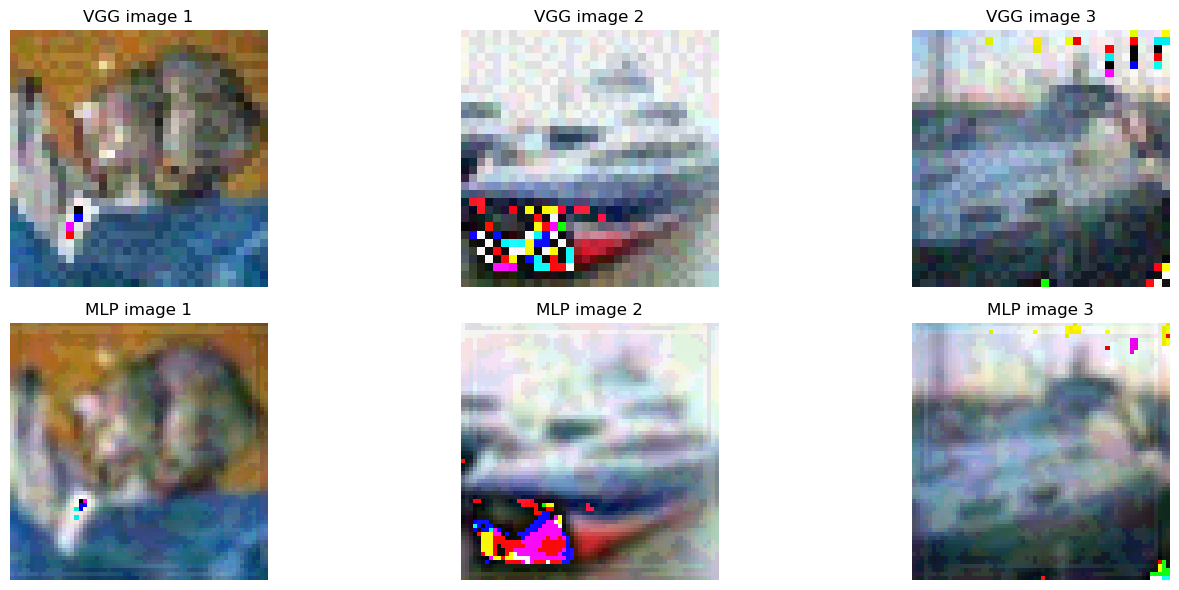

In [16]:
import matplotlib.pyplot as plt
import numpy as np

loaded_dataset_0 = torch.load(altered_datasets[-2])
loaded_dataset_1 = torch.load(altered_datasets[-1])
altered_dataset_0 = CustomDataset(loaded_dataset_0, transform = None)
altered_dataset_1 = CustomDataset(loaded_dataset_1, transform = None)

original = altered_dataset_0[0][0]
altered = altered_dataset_1[0][0]


# Create a subplot for each image
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i in range(3):
    # Original image
    original_image, _ = altered_dataset_0[i]
    axes[0, i].imshow(np.array(original_image))
    axes[0, i].set_title(f'VGG image {i + 1}')

    # Altered image
    altered_image, _ = altered_dataset_1[i]
    axes[1, i].imshow(np.array(altered_image))
    axes[1, i].set_title(f'MLP image {i + 1}')

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

#print(np.array(original_image) - np.array(altered_image))
